**En este ejercicio deben construir 3 modelos de forecasting.**

El dataset utilizado será:
https://data.world/data-society/global-climate-change-data
GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv

De este dataset deberá elegirse la ciudad de Madrid, y realizar el modelado para esta serie únicamente.

El primer modelo debe estar basado en una de las técnicas de baselining descritas en las sesiones prácticas.

El segundo debe estar basado en una algoritmo de machine learning, de entre los mostrados en las sesiones prácticas y los descritos en las sesiones teóricas.

El tercero debe estar basado en aprendizaje profundo, utilizando alguna de las arquitecturas de redes neuronales descritas en las sesiones prácticas.

El entrenamiento debe realizarse con el 80% de los datos, dejando el 20% restante para validación/pruebas.

## Primer modelo basado en una de las técnicas de baselining

In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [ ]:
import pandas as pd

# Cargamos los datos desde el CSV

datos = pd.read_csv("GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv",
                    index_col='dt',
                    parse_dates=True)
print (datos.dtypes)
print (datos.shape)



AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object
(239177, 6)


El DataFrame tiene un total de 239,177 filas y 6 columnas. Esto indica que el conjunto de datos es considerablemente grande y contiene muchas observaciones

In [ ]:
# Mostramos las primeras filas del dataframe para entender su estructura
datos.head()


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [ ]:
data.describe(include='all')

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
count,239177,228175.000000,228175.000000,239177,239177,239177,239177
unique,3239,NaN,NaN,100,49,49,93
top,1983-12-01,NaN,NaN,Rome,India,31.35N,31.38E
freq,100,NaN,NaN,3239,36582,13875,6801
mean,NaN,18.125969,0.969343,NaN,NaN,NaN,NaN
std,NaN,10.024800,0.979644,NaN,NaN,NaN,NaN
min,NaN,-26.772000,0.040000,NaN,NaN,NaN,NaN
25%,NaN,12.710000,0.340000,NaN,NaN,NaN,NaN
50%,NaN,20.428000,0.592000,NaN,NaN,NaN,NaN
75%,NaN,25.918000,1.320000,NaN,NaN,NaN,NaN


In [ ]:
# Filtramos los datos para la ciudad de Madrid
madrid_data = data[data['City'] == 'Madrid'].copy()

# Revisar los datos ausentes
madrid_data.isnull().sum()


dt                                0
AverageTemperature               73
AverageTemperatureUncertainty    73
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64

El conjunto de datos filtrado para la ciudad de Madrid contiene valores faltantes en 73 registros de las columnas AverageTemperature y AverageTemperatureUncertainty.

In [ ]:
madrid_data.shape

(3239, 7)

In [ ]:
# Rellenamos los valores nulos utilizando forward fill
madrid_data_completo = madrid_data.ffill().interpolate()

# Verificamos si hay valores nulos restantes
print(madrid_data_completo.isnull().sum())


dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64


confirmamos que ya no tenemos valores nulos y procedemos a realizar graficas de la temperatura media y la incertidummbre en la temperatura

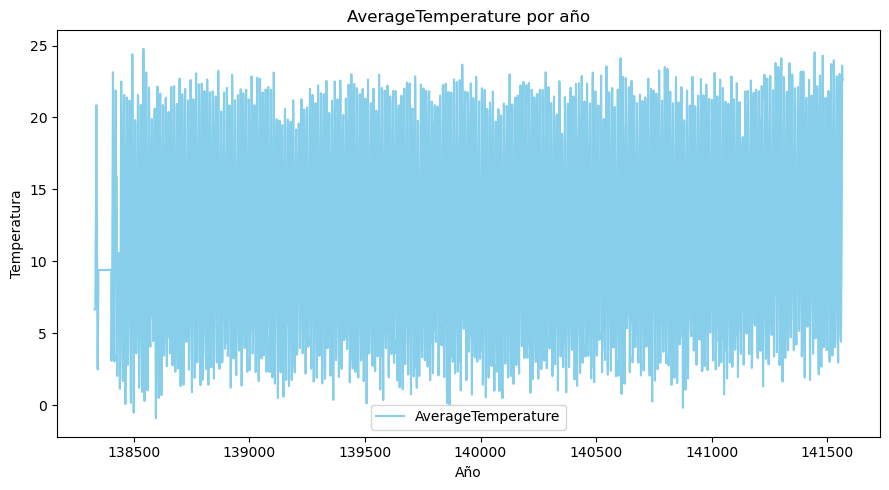

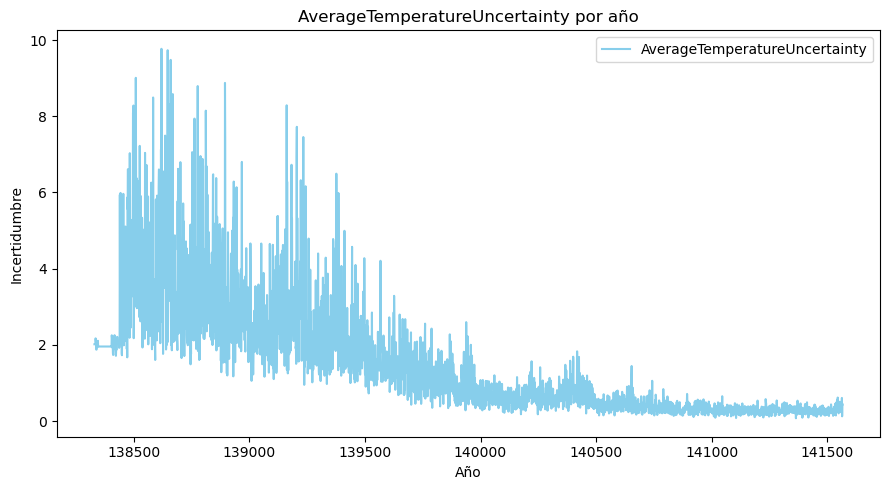

In [ ]:
# Función para graficar datos
def graficar_df(df, col_y, title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    df.plot(y=col_y, ax=ax, marker='', linestyle='-', color='skyblue')
    ax.set_title('Datos Originales' if title is None else title)
    ax.set_xlabel('' if xlabel is None else xlabel)
    ax.set_ylabel('' if ylabel is None else ylabel)
    plt.tight_layout()
    plt.show()

# Graficar la temperatura media y la incertidumbre en la temperatura
graficar_df(madrid_data_completo, 'AverageTemperature', 'AverageTemperature por año', 'Año', 'Temperatura')
graficar_df(madrid_data_completo, 'AverageTemperatureUncertainty', 'AverageTemperatureUncertainty por año', 'Año', 'Incertidumbre')


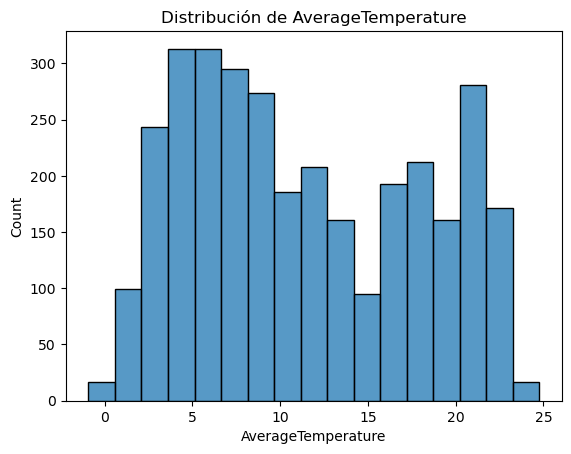

Outliers en AverageTemperature: 0
Outliers en AverageTemperatureUncertainty: 136


In [ ]:
# Histograma para identificar outliers
sns.histplot(madrid_data_completo['AverageTemperature'])
plt.title('Distribución de AverageTemperature')
plt.show()

# Función para identificar outliers utilizando IQR
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data > upper_fence) | (data < lower_fence)]

outliers_temp = iqr_outliers(madrid_data_completo['AverageTemperature'])
outliers_uncertainty = iqr_outliers(madrid_data_completo['AverageTemperatureUncertainty'])

print(f'Outliers en AverageTemperature: {outliers_temp.shape[0]}')
print(f'Outliers en AverageTemperatureUncertainty: {outliers_uncertainty.shape[0]}')


Distribución de Temperaturas:

La distribución de AverageTemperature parece ser razonablemente equilibrada sin valores atípicos significativos, lo que sugiere que las temperaturas promedio en Madrid no tienen variaciones extremas inesperadas.

Incertidumbre en las Mediciones:

La alta cantidad de outliers en AverageTemperatureUncertainty sugiere que en algunas mediciones hubo una incertidumbre considerablemente mayor, lo que puede deberse a problemas en la recolección de datos, condiciones extremas, o errores de medición.

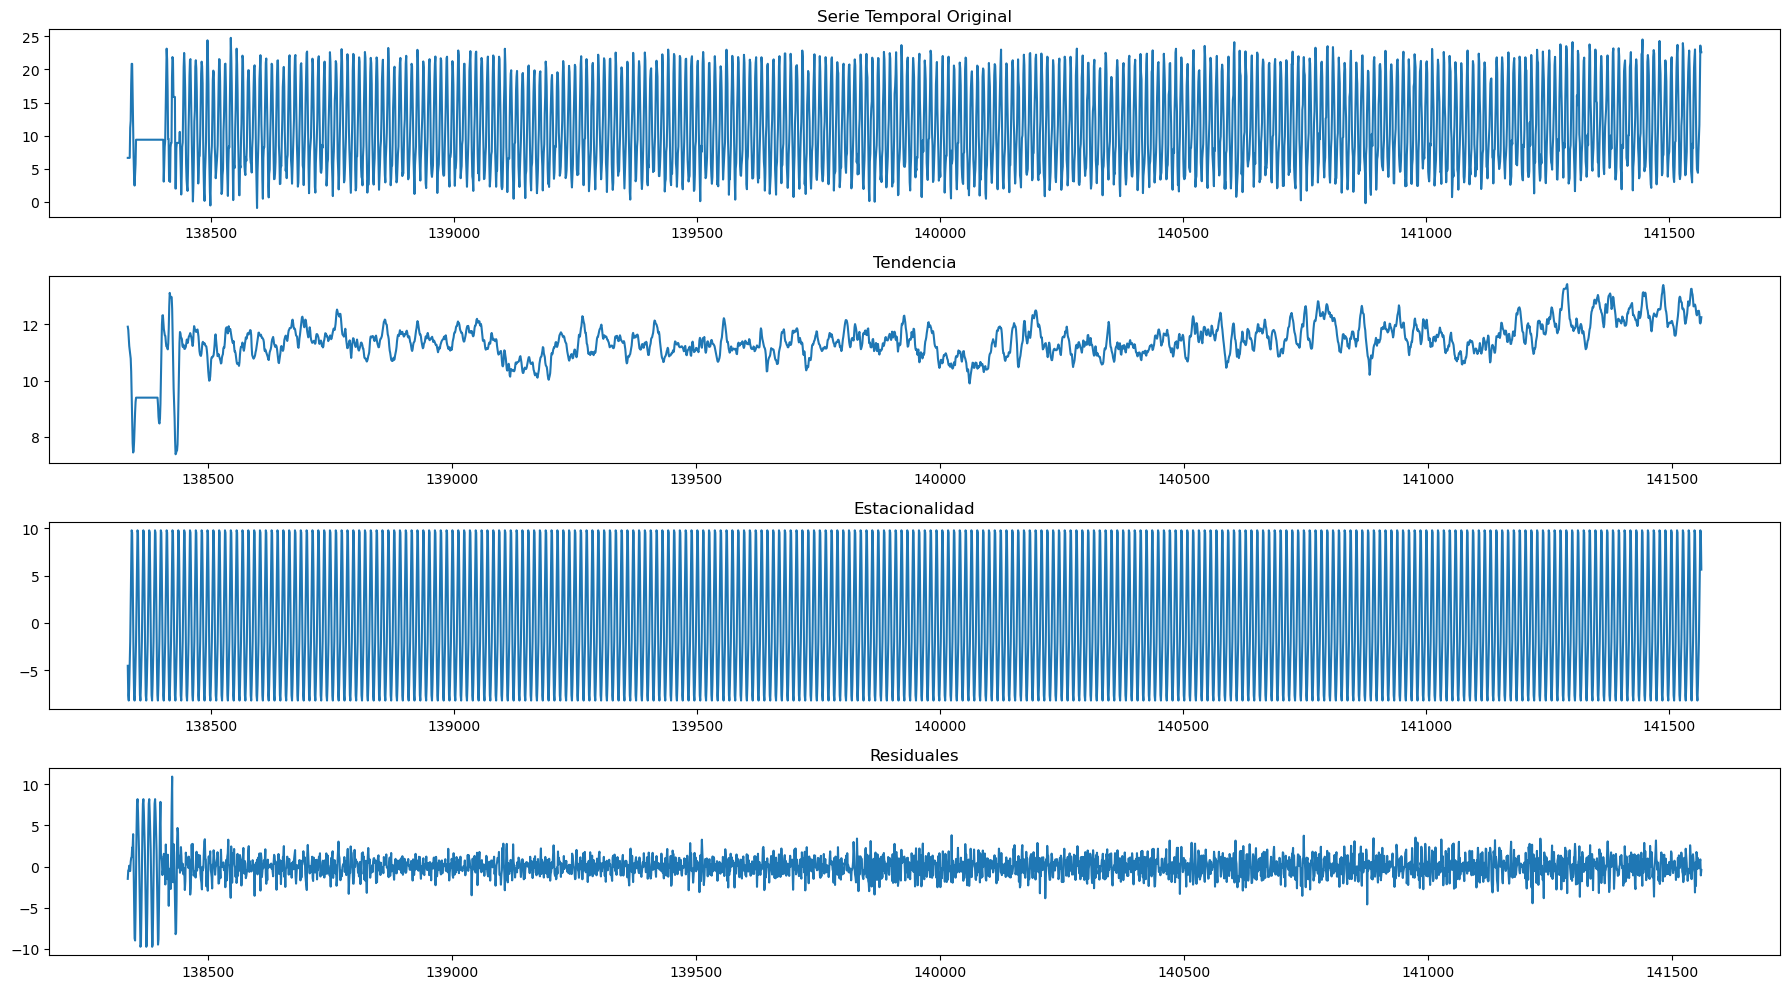

In [ ]:
# Descomposición de la serie temporal especificando el período (mensual)
madrid_decompose = seasonal_decompose(madrid_data_completo['AverageTemperature'], model='additive', period=12)

# Graficar la descomposición
plt.figure(figsize=(18, 10))
plt.subplot(4, 1, 1)
plt.plot(madrid_decompose.observed)
plt.title('Serie Temporal Original')

plt.subplot(4, 1, 2)
plt.plot(madrid_decompose.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 3)
plt.plot(madrid_decompose.seasonal)
plt.title('Estacionalidad')

plt.subplot(4, 1, 4)
plt.plot(madrid_decompose.resid)
plt.title('Residuales')

plt.tight_layout()
plt.show()



### Comprobación de Estacionariedad

Resultados del Test KPSS:
Estadístico               1.058242
p-value                   0.010000
Lags Usados             145.000000
Valor Crítico (10%)       0.347000
Valor Crítico (5%)        0.463000
Valor Crítico (2.5%)      0.574000
Valor Crítico (1%)        0.739000
dtype: float64


C:\Users\PC\AppData\Local\Temp\ipykernel_2316\2874179040.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


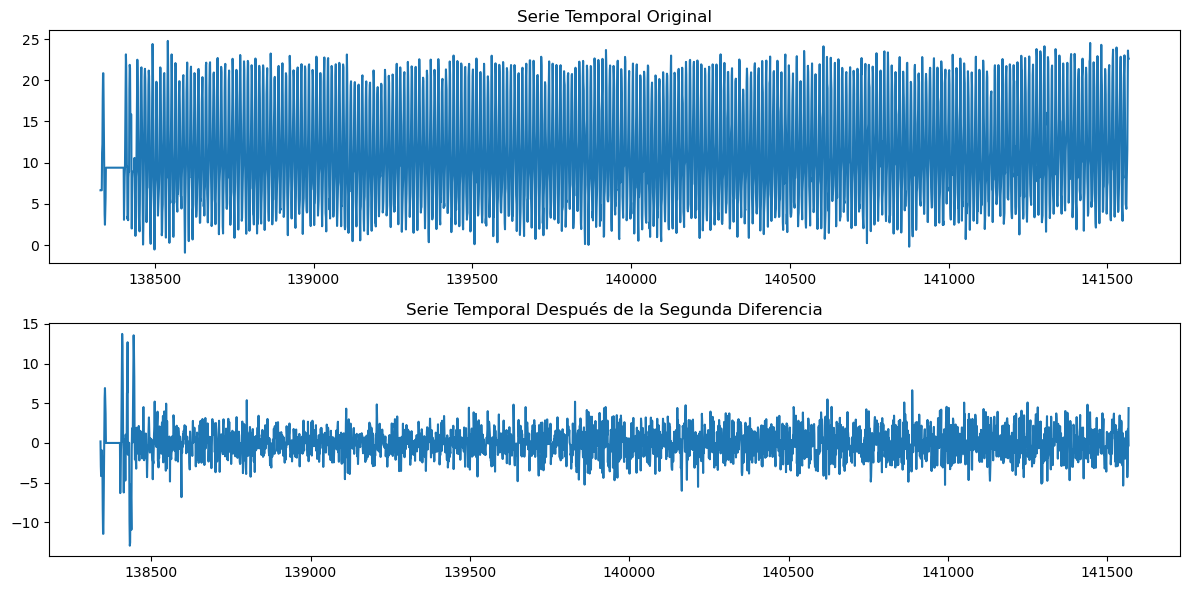

Resultados del Test KPSS:
Estadístico             0.006442
p-value                 0.100000
Lags Usados             7.000000
Valor Crítico (10%)     0.347000
Valor Crítico (5%)      0.463000
Valor Crítico (2.5%)    0.574000
Valor Crítico (1%)      0.739000
dtype: float64


C:\Users\PC\AppData\Local\Temp\ipykernel_2316\2874179040.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [ ]:
from statsmodels.tsa.stattools import kpss, adfuller

def kpss_test(timeseries):
    print("Resultados del Test KPSS:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=["Estadístico", "p-value", "Lags Usados"])
    for key, value in kpsstest[3].items():
        kpss_output["Valor Crítico (%s)" % key] = value
    print(kpss_output)

# Comprobar la estacionariedad
kpss_test(madrid_data_completo['AverageTemperature'])

# Segunda diferenciación para eliminar estacionalidad
diferencia_2orden = madrid_data_completo['AverageTemperature'].diff(12).dropna()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(madrid_data_completo['AverageTemperature'])
plt.title('Serie Temporal Original')

plt.subplot(2, 1, 2)
plt.plot(diferencia_2orden)
plt.title('Serie Temporal Después de la Segunda Diferencia')

plt.tight_layout()
plt.show()

# Comprobar estacionariedad después de la segunda diferencia
kpss_test(diferencia_2orden)


El valor p es menor que 0.05, lo que significa que rechazamos la hipótesis nula de que la serie es estacionaria. Esto indica que la serie temporal original no es estacionaria.

Después de la Segunda Diferenciación. El valor p es mayor que 0.05, lo que significa que no rechazamos la hipótesis nula de que la serie es estacionaria. Esto indica que la serie temporal diferenciada es estacionaria.

Dado que hemos confirmado que la serie temporal diferenciada es estacionaria, podemos proceder con el ajuste del modelo SARIMAX.

### Análisis de Autocorrelación y Autocorrelación Parcial

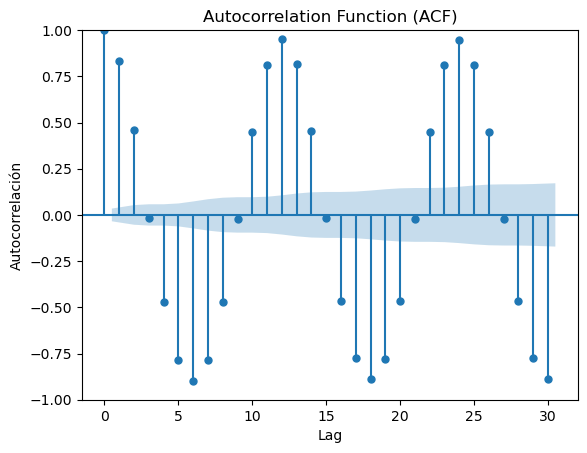

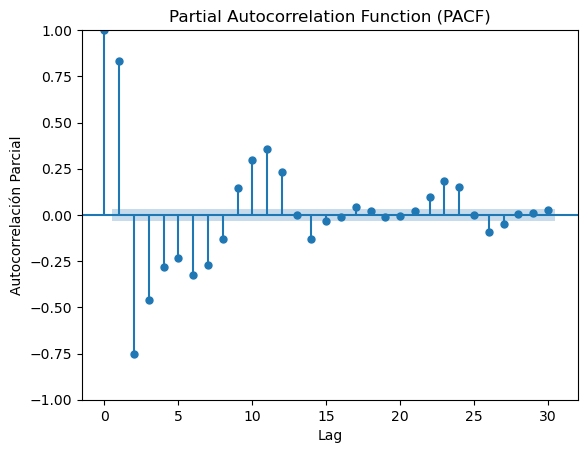

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar la función de autocorrelación (ACF)
plot_acf(madrid_data_completo['AverageTemperature'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()

# Graficar la función de autocorrelación parcial (PACF)
plot_pacf(madrid_data_completo['AverageTemperature'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación Parcial')
plt.show()


La ACF mide la correlación entre una observación en una serie temporal y las observaciones anteriores en diferentes lags (retrasos).

observamos picos significativos en varios lags, lo que sugiere que hay dependencias en múltiples retrasos.

La PACF mide la correlación entre una observación en una serie temporal y las observaciones en diferentes lags, después de eliminar las influencias de los lags intermedios.

El primer lag es significativo, y hay varios otros lags que también son significativos, indicando la presencia de dependencias importantes.

### Ajuste del Modelo SARIMAX

In [ ]:
# Dividir los datos en entrenamiento y prueba
proporción = 0.8
n = len(madrid_data_completo)
entrenamiento = madrid_data_completo.iloc[:int(n * proporción)]
prueba = madrid_data_completo.iloc[int(n * proporción):]

# Ajustar el modelo SARIMAX
sarimax_model = SARIMAX(entrenamiento['AverageTemperature'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
sarimax_fit = sarimax_model.fit(disp=False)

# Realizar predicciones
predicciones_sarimax = sarimax_fit.predict(start=len(entrenamiento), end=len(entrenamiento)+len(prueba)-1, dynamic=False)

# Evaluar el modelo
mse_sarimax = mean_squared_error(prueba['AverageTemperature'], predicciones_sarimax)
print(f'MSE del modelo SARIMAX: {mse_sarimax}')


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MSE del modelo SARIMAX: 12.683706861967991


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


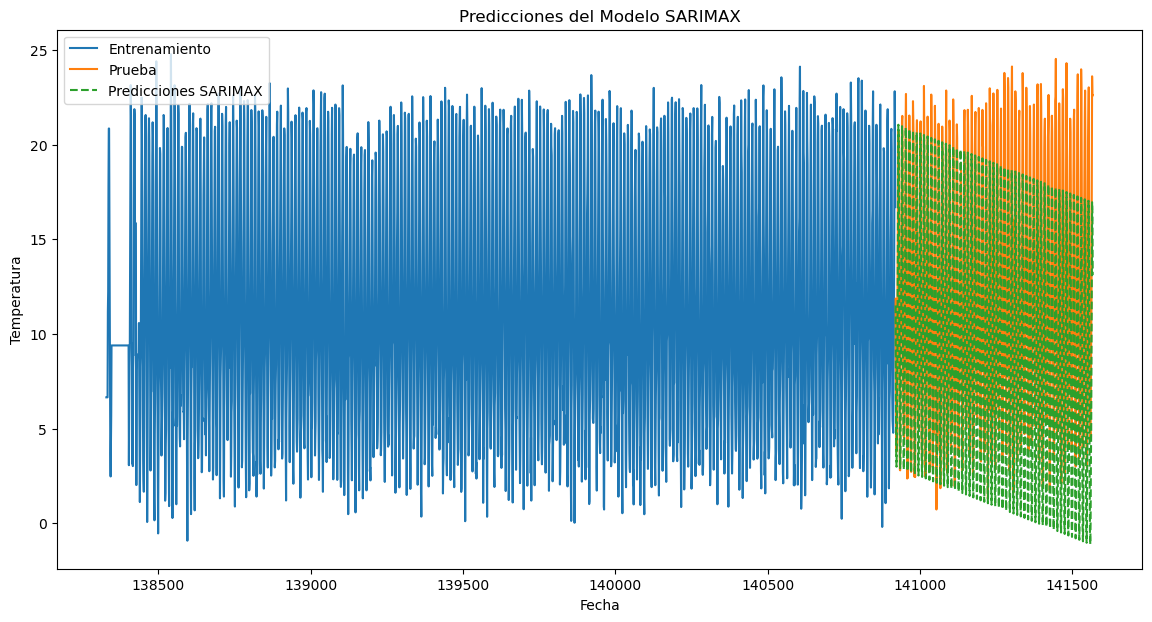

In [ ]:
# Graficar las predicciones junto con los datos reales
plt.figure(figsize=(14, 7))
plt.plot(entrenamiento.index, entrenamiento['AverageTemperature'], label='Entrenamiento')
plt.plot(prueba.index, prueba['AverageTemperature'], label='Prueba')
plt.plot(prueba.index, predicciones_sarimax, label='Predicciones SARIMAX', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Predicciones del Modelo SARIMAX')
plt.legend()
plt.show()


## Segundo  basado en una algoritmo de machine learning

In [ ]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


### Cargar y Preparar los Datos

In [ ]:
# Cargamos los datos desde el CSV
ruta = 'GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv'
datos = pd.read_csv(ruta, index_col='dt', parse_dates=True)

# Filtramos los datos para la ciudad de Madrid
madrid_data = datos[datos['City'] == 'Madrid'].copy()

# Rellenamos los valores nulos utilizando forward fill e interpolación
madrid_data_completo = madrid_data.ffill().interpolate()

# Establecemos la frecuencia del índice a mensual
madrid_data_completo = madrid_data_completo.asfreq('MS')

# Verificamos si hay valores nulos restantes
print("Valores nulos restantes después del relleno:")
print(madrid_data_completo.isnull().sum())


Valores nulos restantes después del relleno:
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64


### Creamos Características para el Modelo

Para los modelos de machine learning, es importante crear características adicionales (features) que puedan ayudar al modelo a aprender mejor las relaciones en los datos.

In [ ]:
# Creamos características basadas en la fecha
madrid_data_completo['Month'] = madrid_data_completo.index.month
madrid_data_completo['Year'] = madrid_data_completo.index.year
madrid_data_completo['Quarter'] = madrid_data_completo.index.quarter

# Creamos retardos (lags)
for lag in range(1, 13):
    madrid_data_completo[f'Lag_{lag}'] = madrid_data_completo['AverageTemperature'].shift(lag)

# Eliminamos filas con valores NaN creados por los lags
madrid_data_completo.dropna(inplace=True)


<Figure size 1200x1000 with 0 Axes>

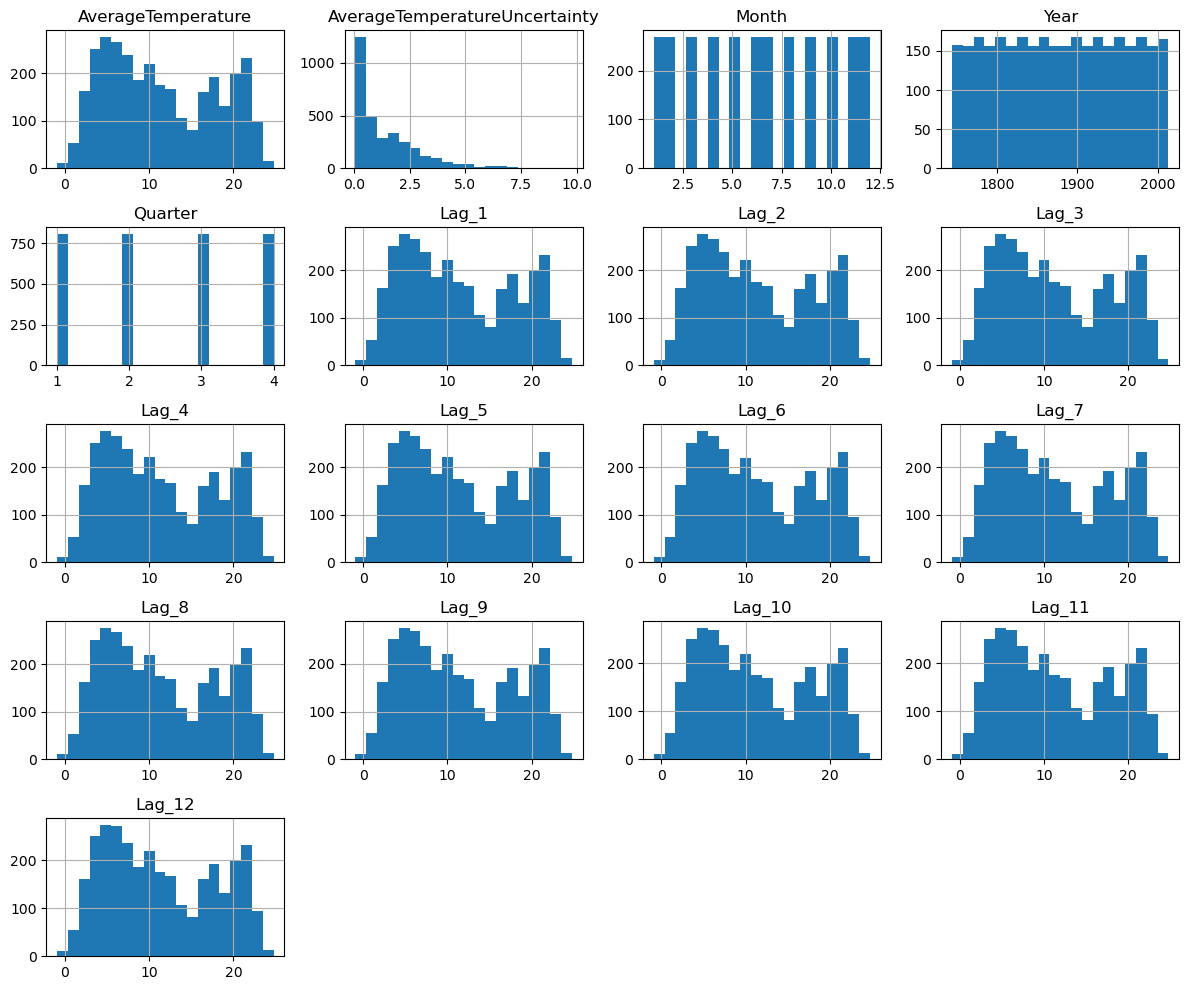

In [ ]:
# Visualizamos la distribución de las características
plt.figure(figsize=(12, 10))
madrid_data_completo.hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()


### Dividir los Datos en Entrenamiento y Prueba

In [ ]:
# Dividimos los datos en características (X) y objetivo (y)
X = madrid_data_completo.drop(columns=['AverageTemperature', 'City', 'Country', 'Latitude', 'Longitude'])
y = madrid_data_completo['AverageTemperature']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)



In [ ]:
# Entrenamos el modelo RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Entrenar el Modelo de RandomForestRegressor

In [ ]:
# Realizamos predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluamos el modelo
mse_rf = mean_squared_error(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)

print(f'MSE del modelo RandomForestRegressor: {mse_rf}')
print(f'MAE del modelo RandomForestRegressor: {mae_rf}')


MSE del modelo RandomForestRegressor: 2.490568270631734
MAE del modelo RandomForestRegressor: 1.2433654334365325


El MSE mide el promedio de los cuadrados de los errores, es decir, la diferencia promedio entre los valores reales y los valores predichos. Un MSE de 2.49 indica que, en promedio, los cuadrados de los errores de predicción son 2.49 grados Celsius. Un valor más bajo de MSE es mejor, ya que indica que el modelo está haciendo predicciones más precisas.

El MAE mide el promedio de los errores absolutos, es decir, la diferencia promedio entre los valores reales y los valores predichos en términos absolutos. Un MAE de 1.24 indica que, en promedio, las predicciones del modelo tienen un error de aproximadamente 1.24 grados Celsius. Al igual que con el MSE, un valor más bajo de MAE es mejor.

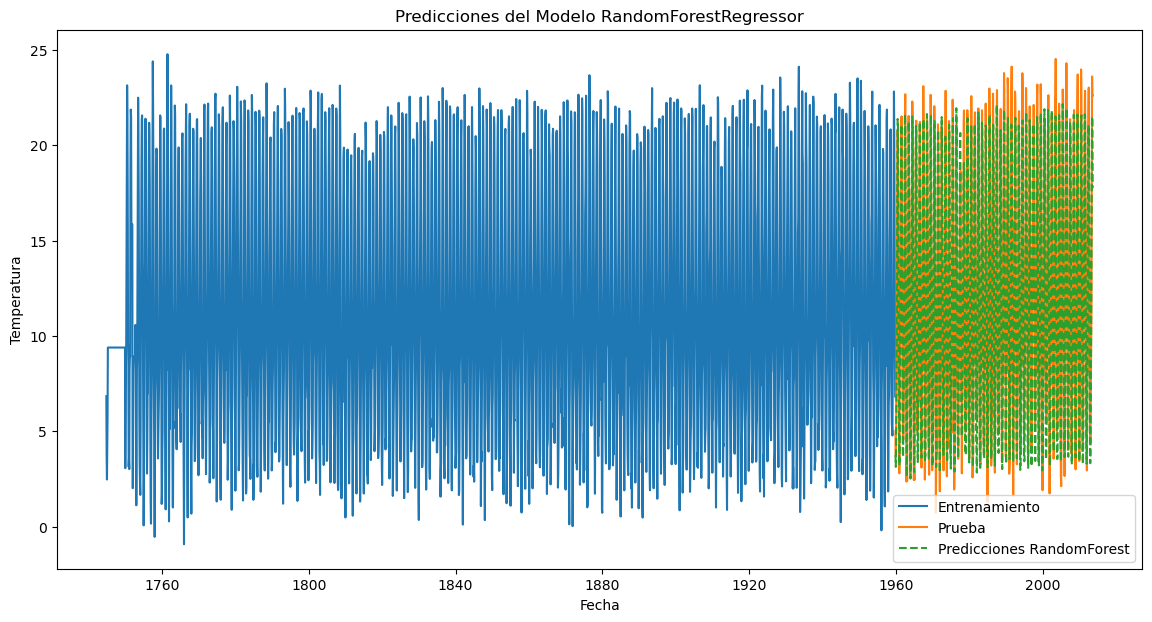

In [ ]:
# Graficamos las predicciones junto con los datos reales
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Entrenamiento')
plt.plot(y_test.index, y_test, label='Prueba')
plt.plot(y_test.index, y_pred, label='Predicciones RandomForest', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Predicciones del Modelo RandomForestRegressor')
plt.legend()
plt.show()


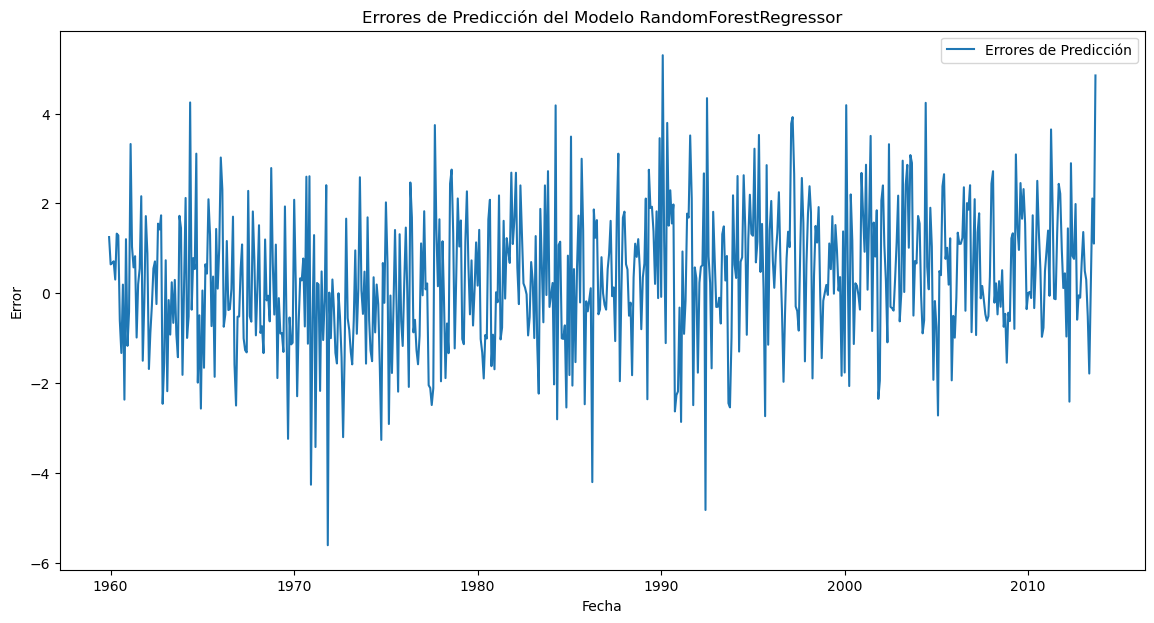

In [ ]:
# Visualizamos los errores de predicción
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test - y_pred, label='Errores de Predicción')
plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Errores de Predicción del Modelo RandomForestRegressor')
plt.legend()
plt.show()


## Tercer modelo aplicando aprendizaje profundo

Utilizaremos una arquitectura de aprendizaje profundo, específicamente una red neuronal LSTM (Long Short-Term Memory). Las LSTM son adecuadas para el modelado de series temporales debido a su capacidad para recordar patrones de datos a largo plazo.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [8]:
# Cargamos los datos desde el CSV
ruta = '/content/drive/My Drive/GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv'
datos = pd.read_csv(ruta, index_col='dt', parse_dates=True)

# Filtramos los datos para la ciudad de Madrid
madrid_data = datos[datos['City'] == 'Madrid'].copy()

# Rellenamos los valores nulos utilizando forward fill e interpolación
madrid_data_completo = madrid_data.ffill().interpolate()

# Establecemos la frecuencia del índice a mensual
madrid_data_completo = madrid_data_completo.asfreq('MS')

# Verificamos si hay valores nulos restantes
print("Valores nulos restantes después del relleno:")
print(madrid_data_completo.isnull().sum())


Valores nulos restantes después del relleno:
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64


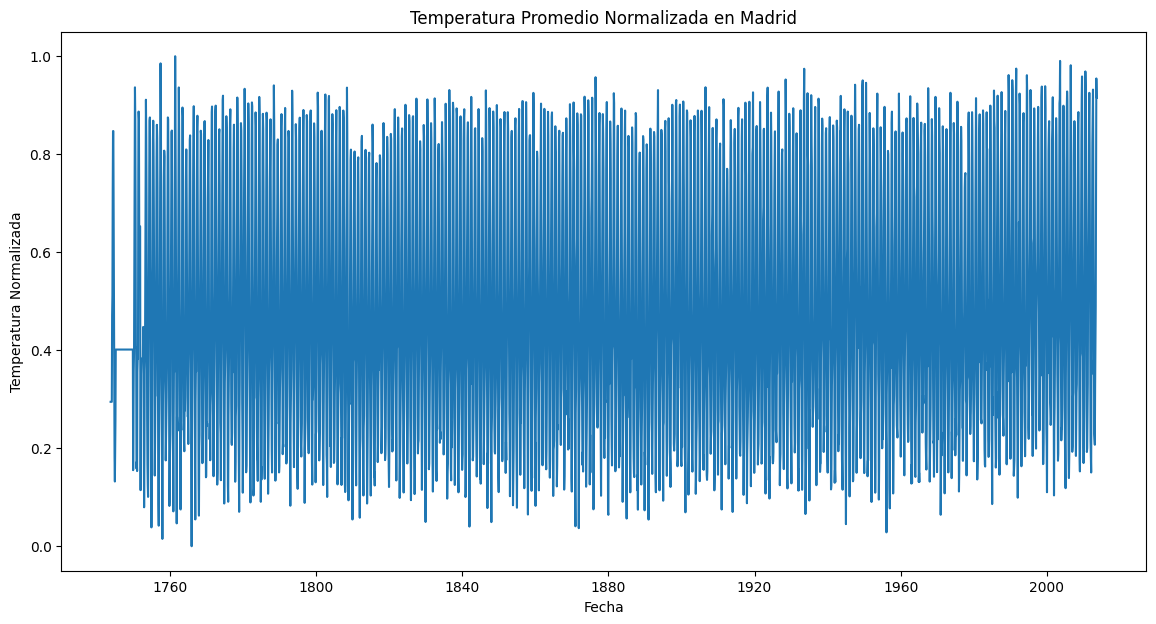

In [9]:
# Normalizamos los datos de temperatura
scaler = MinMaxScaler(feature_range=(0, 1))
madrid_data_completo['ScaledTemperature'] = scaler.fit_transform(madrid_data_completo[['AverageTemperature']])

# Visualizamos los datos normalizados
plt.figure(figsize=(14, 7))
plt.plot(madrid_data_completo.index, madrid_data_completo['ScaledTemperature'])
plt.title('Temperatura Promedio Normalizada en Madrid')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Normalizada')
plt.show()









**Crear Conjuntos de Entrenamiento y Prueba**

In [10]:
# Creamos las secuencias para el modelo LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Definimos el tamaño de la secuencia
seq_length = 12

# Creamos las secuencias de entrenamiento y prueba
train_size = int(len(madrid_data_completo) * 0.8)
train_data = madrid_data_completo['ScaledTemperature'].values[:train_size]
test_data = madrid_data_completo['ScaledTemperature'].values[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape para LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


**Construir el Modelo LSTM**

In [11]:
# Construimos el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilamos el modelo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 12, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Entrenar el Modelo**

Epoch 1/100
162/162 [==============================] - 16s 31ms/step - loss: 0.0695 - val_loss: 0.0071
Epoch 2/100
162/162 [==============================] - 4s 22ms/step - loss: 0.0120 - val_loss: 0.0090
Epoch 3/100
162/162 [==============================] - 3s 19ms/step - loss: 0.0103 - val_loss: 0.0049
Epoch 4/100
162/162 [==============================] - 2s 12ms/step - loss: 0.0088 - val_loss: 0.0067
Epoch 5/100
162/162 [==============================] - 2s 12ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 6/100
162/162 [==============================] - 2s 12ms/step - loss: 0.0083 - val_loss: 0.0046
Epoch 7/100
162/162 [==============================] - 2s 11ms/step - loss: 0.0077 - val_loss: 0.0049
Epoch 8/100
162/162 [==============================] - 2s 12ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 9/100
162/162 [==============================] - 3s 16ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 10/100
162/162 [==============================] - 3s 19ms/step - loss: 0.00

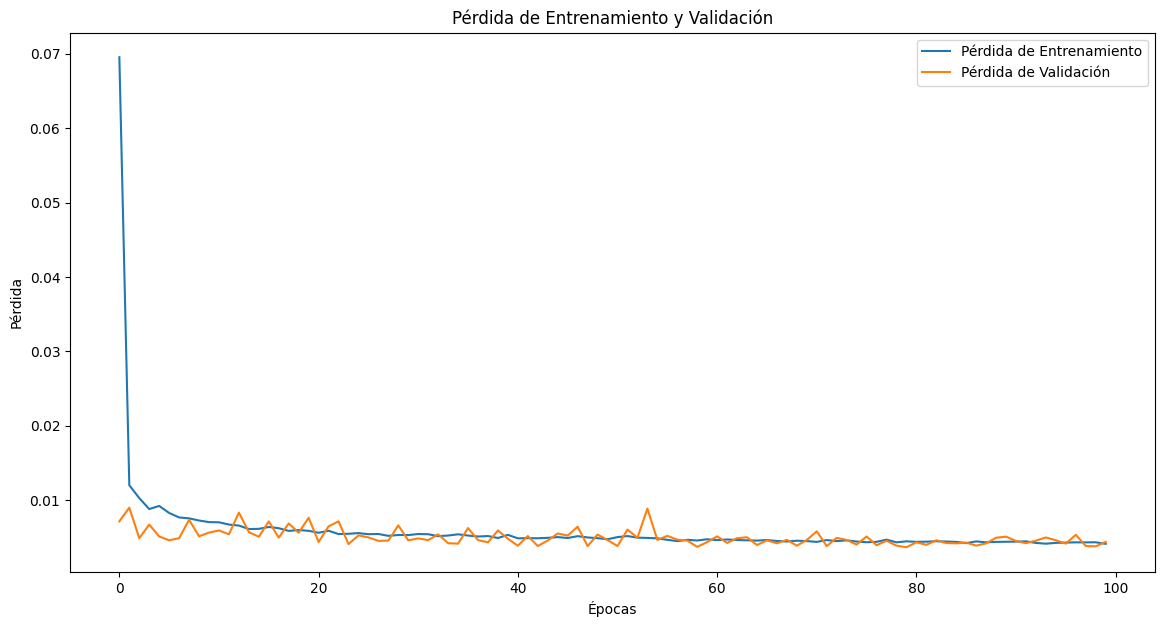

In [12]:
# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=16, verbose=1)

# Visualizamos la pérdida de entrenamiento y validación
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


**Realizar Predicciones y Evaluar el Modelo**

In [13]:
# Realizamos predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Desnormalizamos las predicciones y los valores reales
y_test_descaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_descaled = scaler.inverse_transform(y_pred)

# Evaluamos el modelo
mse_lstm = mean_squared_error(y_test_descaled, y_pred_descaled)
mae_lstm = mean_absolute_error(y_test_descaled, y_pred_descaled)

print(f'MSE del modelo LSTM: {mse_lstm}')
print(f'MAE del modelo LSTM: {mae_lstm}')


20/20 [==============================] - 1s 7ms/step
MSE del modelo LSTM: 2.8941811014865966
MAE del modelo LSTM: 1.3086499520517747


El modelo LSTM ha logrado un MSE de aproximadamente 2.89 y un MAE de aproximadamente 1.31, lo que indica un desempeño razonable, con errores de predicción relativamente pequeños.

Comparado con el modelo RandomForestRegressor, el modelo LSTM tiene un MSE y un MAE ligeramente más altos, lo que sugiere que el RandomForestRegressor podría estar capturando mejor las relaciones en los datos de esta serie temporal específica.

**Visualizar las Predicciones**

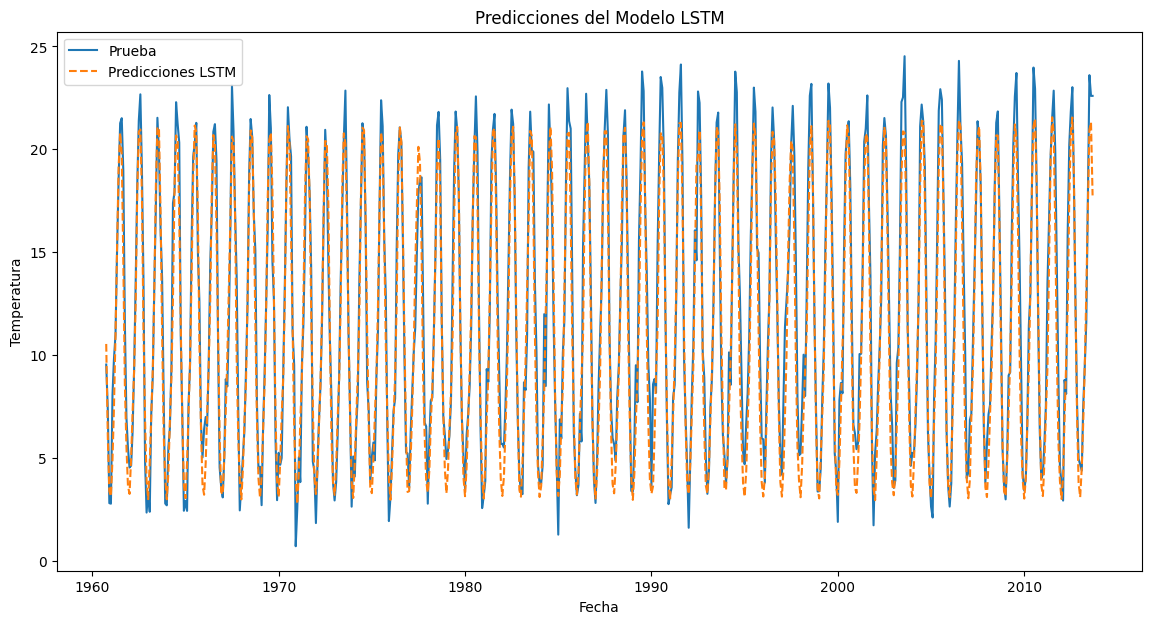

In [14]:
# Graficamos las predicciones junto con los datos reales
plt.figure(figsize=(14, 7))
plt.plot(madrid_data_completo.index[train_size + seq_length:], y_test_descaled, label='Prueba')
plt.plot(madrid_data_completo.index[train_size + seq_length:], y_pred_descaled, label='Predicciones LSTM', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Predicciones del Modelo LSTM')
plt.legend()
plt.show()


**Visualización de los Errores de Predicción**

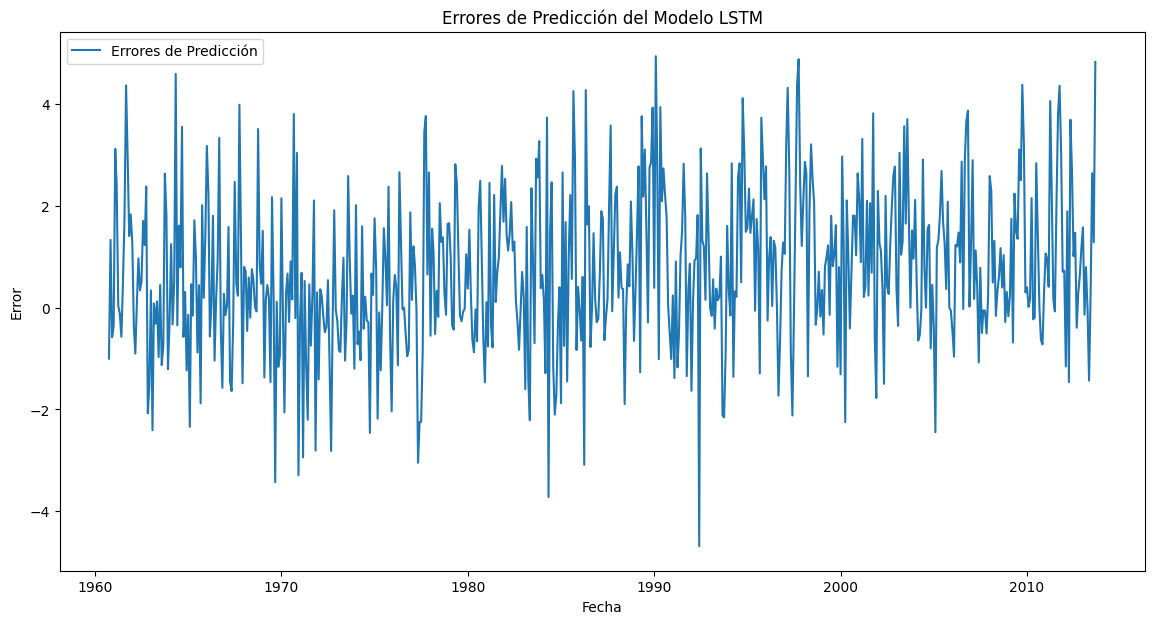

In [15]:
# Visualizamos los errores de predicción
plt.figure(figsize=(14, 7))
plt.plot(madrid_data_completo.index[train_size + seq_length:], y_test_descaled - y_pred_descaled, label='Errores de Predicción')
plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Errores de Predicción del Modelo LSTM')
plt.legend()
plt.show()
